# **Weather Forecasting Project - Part 2**

**Statistical Models for Data Science**

**Marco Colognesi - VR495478**

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_arch
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

Importing **training** and **testing** data:

In [4]:
# Importing train dataset
train_data = pd.read_csv(
    filepath_or_buffer="cleaned_data/train_clean.csv",
    parse_dates=['date'],
    index_col=['date'],
)

# Imposing data frequency as daily
train_data = train_data.asfreq('D')

# Lowercase column names
train_data.columns = train_data.columns.str.lower()

display(train_data)

,meantemp,humidity,wind_speed,meanpressure,month,year
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013
2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013
2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013
2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013
...,...,...,...,...,...,...
2016-12-27,16.850000,67.550000,8.335000,1017.200000,12,2016
2016-12-28,17.217391,68.043478,3.547826,1015.565217,12,2016
2016-12-29,15.238095,87.857143,6.000000,1016.904762,12,2016


In [5]:
# Importing test data
test_data = pd.read_csv(
    filepath_or_buffer="cleaned_data/test_clean.csv",
    parse_dates=['date'],
    index_col=['date']
)

# Imposing frequency
test_data = test_data.asfreq('D')

# Lowercase column names
test_data.columns = test_data.columns.str.lower()

display(test_data)

,meantemp,humidity,wind_speed,meanpressure,month,year
date,,,,,,
2017-01-01,15.913043,85.869565,2.743478,1018.277778,1,2017
2017-01-02,18.500000,77.222222,2.894444,1018.277778,1,2017
2017-01-03,17.111111,81.888889,4.016667,1018.333333,1,2017
2017-01-04,18.700000,70.050000,4.545000,1015.700000,1,2017
2017-01-05,18.388889,74.944444,3.300000,1014.333333,1,2017
...,...,...,...,...,...,...
2017-03-27,29.500000,38.625000,13.650000,1009.500000,3,2017
2017-03-28,29.888889,40.666667,8.844444,1009.000000,3,2017
2017-03-29,31.000000,34.500000,13.200000,1007.125000,3,2017


## **Multiple Linear Regression**

The first forecasting model that will be tested is the **multiple linear regression**: a statistical method used to understand the **relationship** between **two or more** **independent variables** and a **single dependent variable**.

### **Multiple Linear Regression using `'humidity'`, `'wind_speed'`, `'meanpressure'`**

The first version of this implementation will use as **independent variables** (*predictors*), the variables already present in the source dataset: `"humidity"`, `"wind_speed"`, and `"meanpressure"`. The purpose is to predict the variable `"meantemp"`, which will be evaluated on both training and testing datasets.

                            OLS Regression Results                            
Dep. Variable:               meantemp   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3113.
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:15:09   Log-Likelihood:                -3521.6
No. Observations:                1461   AIC:                             7051.
Df Residuals:                    1457   BIC:                             7072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          820.0381     10.416     78.728   

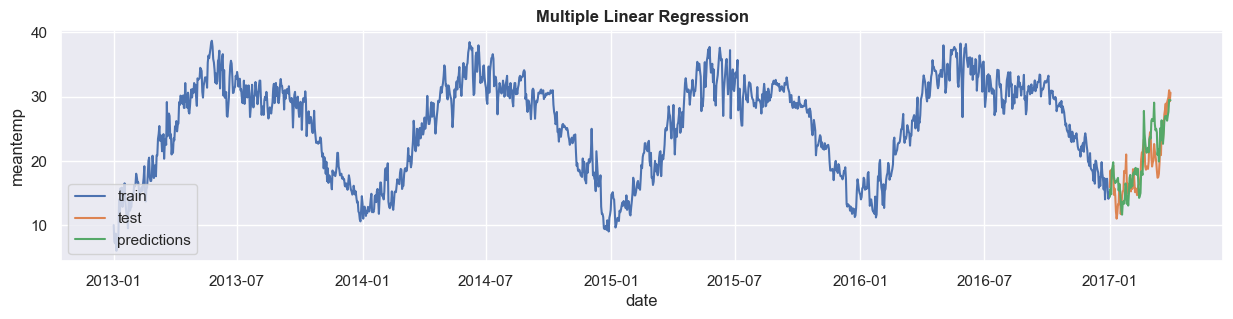

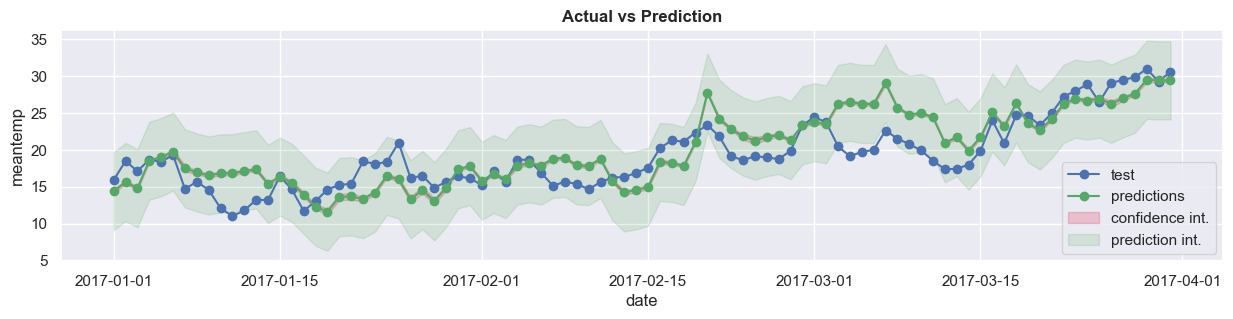

Evaluation on test set: 
R2: 0.59072716208202
RMSE: 2.9824072340294006
MAE: 2.4309679154425345


In [33]:
# Multiple linear regression using "humidity", "wind_speed", "meanpressure"

# Training dataset
X_train = train_data[['humidity', 'wind_speed', 'meanpressure']]
y_train = train_data['meantemp']

# Testing dataset
X_test = test_data[['humidity', 'wind_speed', 'meanpressure']]
y_test = test_data['meantemp']

# Fitting the model
X_train = sm.add_constant(X_train)  # in statsmodels we need to manually add constant otherwise b=0
reg = sm.OLS(y_train, X_train).fit()

# Printing regression summary
print(reg.summary())

# Making predictions on test data
X_test = sm.add_constant(X_test)
df_predictions = reg.get_prediction(X_test).summary_frame(alpha=0.05)
preds = df_predictions['mean'].values

# Plotting predictions vs actual values
plt.figure(figsize=(15,3))
plt.title(f"Multiple Linear Regression", weight="bold")
plt.plot(train_data.index, y_train, label='train')
plt.plot(test_data.index, y_test, label='test')
plt.plot(test_data.index, preds, label='predictions')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='lower left')
plt.show()

# Plotting predictions vs actual values
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction", weight="bold")
plt.plot(test_data.index, y_test, 'o-' ,label='test')
plt.plot(test_data.index, preds, 'go-', label='predictions')
plt.fill_between(test_data.index, df_predictions.mean_ci_lower, df_predictions.mean_ci_upper, alpha=.2, color='crimson', label = 'confidence int.')
plt.fill_between(test_data.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='green',label='prediction int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='best')
plt.show()

r2_test = r2_score(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"=============================")
print(f"Evaluation on test set: \nR2: {r2_test}\nRMSE: {rmse}\nMAE: {mae}")

The result on the training model is not bad, as the **R2** presents a value of `0.865`, however, **several issues** can be observed that make the model unsuitable.

First of all, as suggested by the summary provided by statsmodels, a **strong multicollinearity problem** is present. This occurs when the predictors are highly correlated with each other, making it difficult to distinguish the individual effects of the variables on the target.
The summary report also shows that the `Durbin-Watson = 0.327`, meaning that there could be problems in our residuals (_evidence of positive **correlation**_).

In addition, evaluating the model on the test dataset it is possible to observe a **collapse** of R2 to `0.59`, signal that the model is not very effective in making predictions.

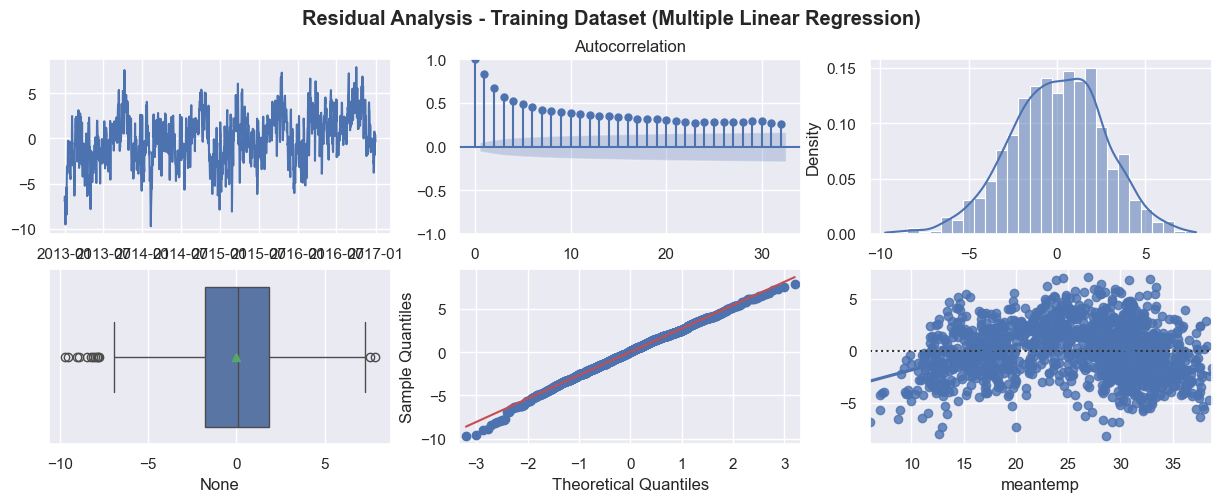

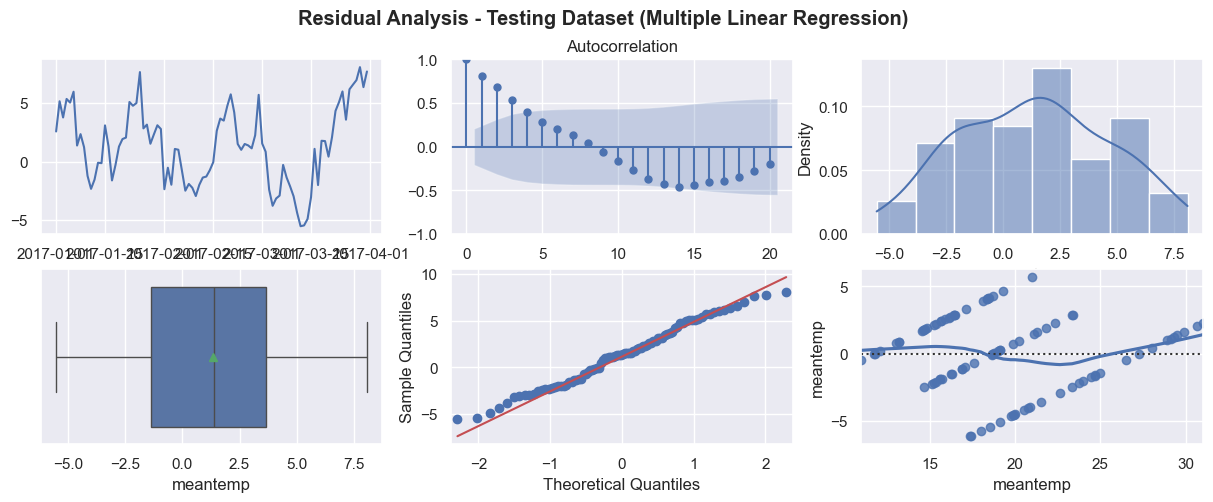

In [35]:
# Training Residuals
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Training Dataset (Multiple Linear Regression)', weight='bold')
ax[0,0].plot(reg.resid)
plot_acf(reg.resid, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(reg.resid, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=reg.resid, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(reg.resid, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=reg.resid, x=y_train, lowess=True, ax=ax[1,2])
plt.show()


# Test Residuals
residuals = y_test - preds_test

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Testing Dataset (Multiple Linear Regression)', weight='bold')
ax[0,0].plot(residuals)
plot_acf(residuals, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals, x=y_test, lowess=True, ax=ax[1,2])
plt.show()

Even when analyzing the residuals (difference between prediction and actual value) it is possible to see problems in the model:

* Their **distribution** shows discrepancies: the **histogram** does not reflect a typical "bell curve" but shows a strong presence of negative errors (**left-shifted curve**, presence of **skewness**), which is also reiterated by the **boxplot** (their distribution should be symmetrical, with the sides of the boxplot having approximately the same length).
* The **qq-plot** shows deviations from the diagonal line, suggesting, again, skewness in the distribution.
* The **residplot** doesn't reflect a strict horizontal trend.

Even when analyzing the relationship between residuals and predictors, problems can be observed.

* **Autocorrelation** function shows that the residuals are not independent of each other, suggesting that the model fails to capture underlying dependencies or time series structures adequately. Recall that this problem was suggested by the Durbin-Watson test result shown in the regression summary.
* Residuals also show **relationships** with the **predictors**, rather than showing independence.

Let us see if by adding **date-related information** in the implementation the model shows improvement.

Specifically, a **one-hot encoding** on the months will be performed.
This means that our dataset will have a dummy variable for each month, whose value will be `True (1)` or `False (0)` depending on the observation date.

### **Multiple Linear Regression using One-Hot Encoding on 'Month' variable**

In [24]:
# Creating a dummy dataframe containing encoded variables on train data
dummy_df_train = pd.DataFrame(data=pd.get_dummies(train_data.index.month, drop_first=True, prefix='month'))
dummy_df_train.index = train_data.index

# Converting Booleans (True and False) to integers (1 and 0)
dummy_df_train = dummy_df_train.astype(int)

display(dummy_df_train.head())

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
2013-01-01,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,0,0,0,0,0,0,0,0,0,0,0


We perform it also on the test set to have a matching structure between the two datasets.

To deal with missing columns some additional steps are required (_in the test set we only get from January to March_).

In [22]:
# Creating dummy dataframe containing encoded variables on test data
dummy_df_test = pd.DataFrame(data=pd.get_dummies(test_data.index.month, drop_first=True, prefix='month'))
dummy_df_test.index = test_data.index

# Converting into int
dummy_df_test = dummy_df_test.astype(int)

# Adding to dummy_df_test missing columns from dummy_df_train (so that they can match)
missing_cols = list(set(dummy_df_train.columns) - set(dummy_df_test.columns))

# sorting missing months for better ordering (we split 'month_X' in ['month', 'X'] and sort by the last element in the list)
sorted_missing_cols = sorted(missing_cols, key=lambda x : int(x.split('_')[1]))

for month in sorted_missing_cols:
    dummy_df_test[month] = 0
    
display(dummy_df_test)

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,1,0,0,0,0,0,0,0,0,0
2017-03-28,0,1,0,0,0,0,0,0,0,0,0
2017-03-29,0,1,0,0,0,0,0,0,0,0,0


                            OLS Regression Results                            
Dep. Variable:               meantemp   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     912.0
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:13:31   Log-Likelihood:                -3472.7
No. Observations:                1461   AIC:                             6969.
Df Residuals:                    1449   BIC:                             7033.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3386      0.235     56.751      0.0

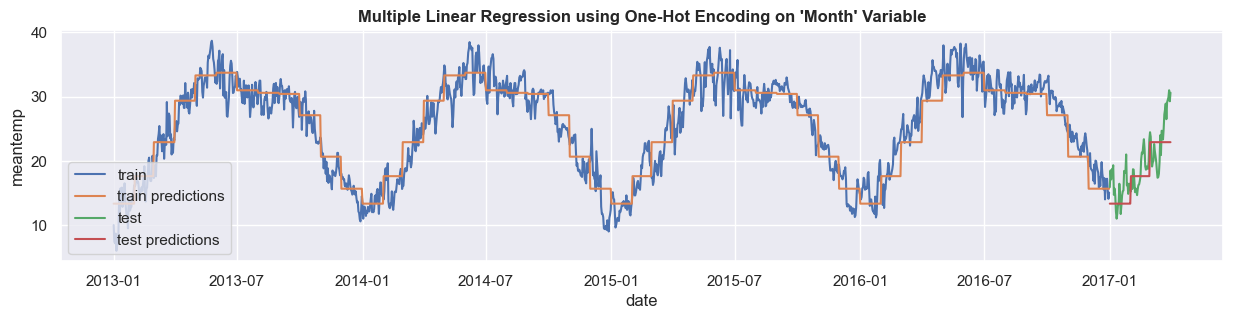

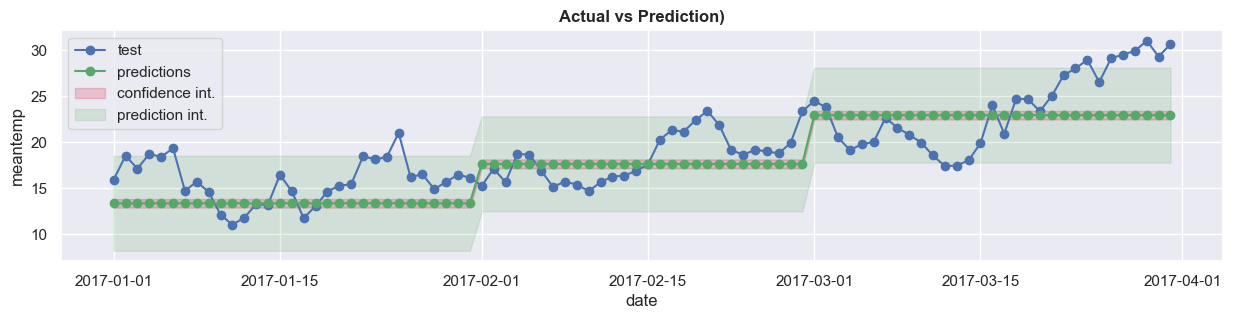

Evaluation on test set: 
R2: 0.42347626347906087
RMSE: 3.539721379709381
MAE: 2.941063619541184


In [31]:
# Identifying independent and dependent variables

# train
X_train = dummy_df_train
y_train = train_data['meantemp']

# test
X_test = dummy_df_test
y_test = test_data['meantemp']

# Linear Regression using statsmodels
X_train_c = sm.add_constant(X_train)
reg = sm.OLS(y_train, X_train_c).fit()

# printing summary result on test data
print(reg.summary())

# predictions

# train
preds_train = reg.predict(X_train_c)

# test
X_test_c = sm.add_constant(X_test)
df_predictions_test = reg.get_prediction(X_test_c).summary_frame(alpha=0.05)
preds_test = df_predictions_test['mean'].values

# Plotting predictions vs actual values
plt.figure(figsize=(15,3))
plt.title(f"Multiple Linear Regression using One-Hot Encoding on 'Month' Variable", weight="bold")
plt.plot(train_data.index, y_train, label='train')
plt.plot(train_data.index, preds_train, label='train predictions')
plt.plot(test_data.index, y_test, label='test')
plt.plot(test_data.index, preds_test, label='test predictions')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='lower left')
plt.show()

# Plotting predictions vs actual values
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction)", weight="bold")
plt.plot(test_data.index, y_test, 'o-' ,label='test')
plt.plot(test_data.index, preds_test, 'go-', label='predictions')
plt.fill_between(test_data.index, df_predictions_test.mean_ci_lower, df_predictions_test.mean_ci_upper, alpha=.2, color='crimson', label = 'confidence int.')
plt.fill_between(test_data.index, df_predictions_test.obs_ci_lower, df_predictions_test.obs_ci_upper, alpha=.1, color='green',label='prediction int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='best')
plt.show()

r2_test = r2_score(y_test, preds_test)
rmse = root_mean_squared_error(y_test, preds_test)
mae = mean_absolute_error(y_test, preds_test)

print(f"=============================")
print(f"Evaluation on test set: \nR2: {r2_test}\nRMSE: {rmse}\nMAE: {mae}")

Using this method a slightly better result was achieved on the training dataset, while a **worse performance** was found on the testing dataset with an **R2** of `0.42`, a symptom that multiple linear regression is not among the best methods for making accurate forecasting on time series, as it cannot best capture its main components.

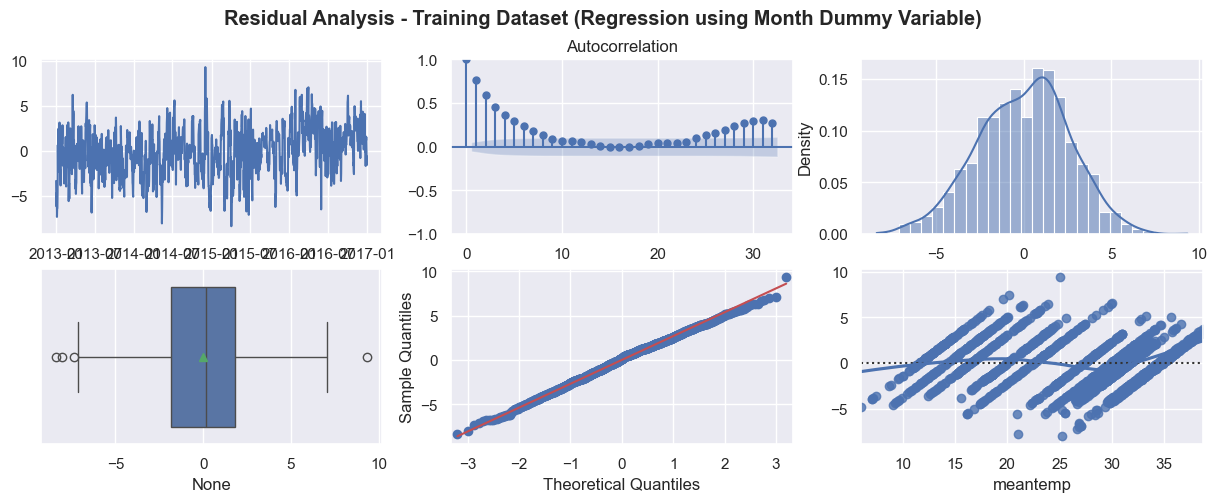

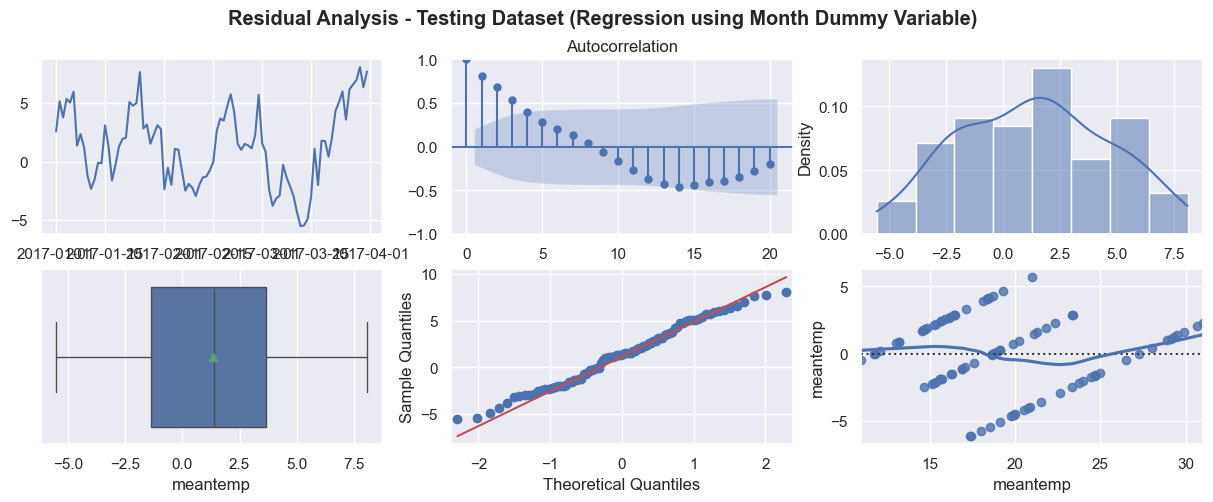

In [32]:
# Training Residuals
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Training Dataset (Regression using Month Dummy Variable)', weight='bold')
ax[0,0].plot(reg.resid)
plot_acf(reg.resid, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(reg.resid, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=reg.resid, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(reg.resid, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=reg.resid, x=y_train, lowess=True, ax=ax[1,2])
plt.show()


# Test Residuals
residuals = y_test - preds_test

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Testing Dataset (Regression using Month Dummy Variable)', weight='bold')
ax[0,0].plot(residuals)
plot_acf(residuals, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals, x=y_test, lowess=True, ax=ax[1,2])
plt.show()

Analyzing the **residuals** obtained by this method we can again observe **problems** regarding **autocorrelation**. In fact, the errors do not show independence with each other. Moreover, their distribution is not centered around 0.

## **Holt-Winters Exponential Smoothing**

**Holt-Winters** is an **exponential smoothing** technique used to capture **level**, **trend** and **seasonality** in the data.
It is a simple and flexible technique that adapts to changes in the data's behavior by adjusting smoothing parameters for each component.

### **First Implementation**

c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 ETS Results                                  
Dep. Variable:               meantemp   No. Observations:                 1461
Model:                       ETS(AAA)   Log Likelihood               -2652.063
Date:                Wed, 03 Apr 2024   AIC                           6046.126
Time:                        20:04:01   BIC                           8007.557
Sample:                    01-01-2013   HQIC                          6777.793
                         - 12-31-2016   Scale                            2.209
Covariance Type:               approx                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.9999      0.024     41.104      0.000       0.952       1.048
smoothing_trend       9.999e-05        nan        nan        nan         nan         nan
smoothing_se

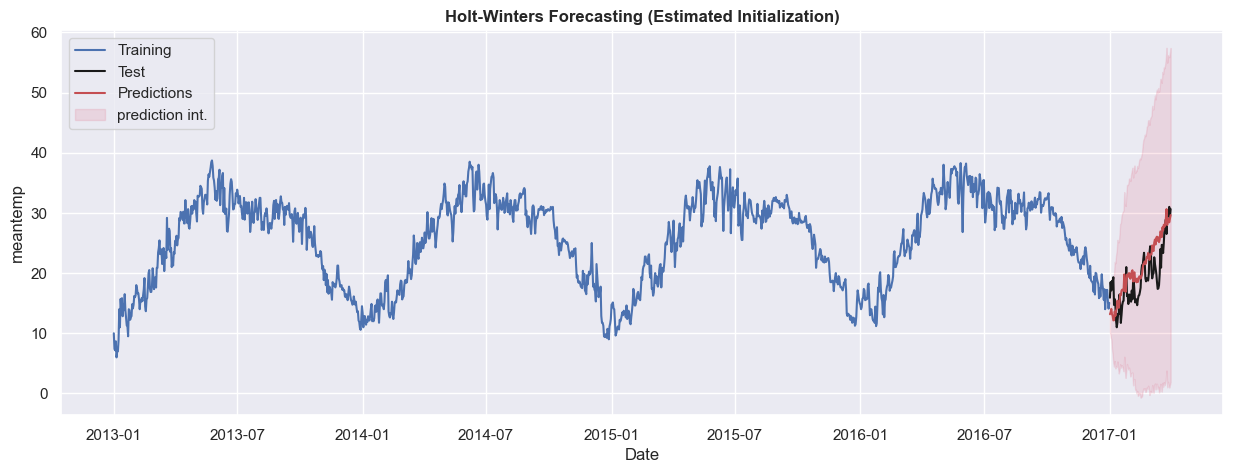

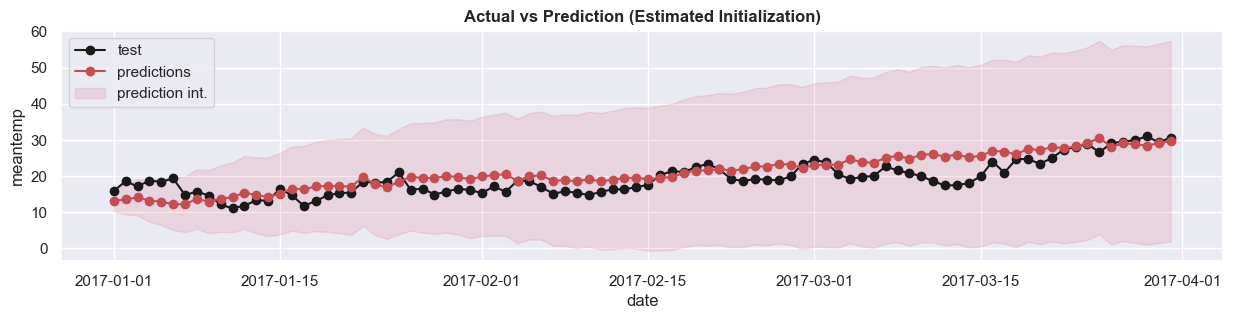

-- Training Evaluation (estimated initialization)--
MAE training set:  1.1141872919530669
MSE training set:  2.2091309700139705
RMSE training set:  1.4863145595781435

-- Testing Evaluation (estimated initialization) --
MAE test set:  2.9472802462772214
MSE test set:  12.22434871133725
RMSE test set:  12.22434871133725
R2 test set:  0.4375230048950166


In [13]:
# focus on forecasting meantemp (avoid other variables)
meantemp_train = train_data['meantemp']
meantemp_test = test_data['meantemp']

# Initializing and fitting the model (estimated initialization)
model_estimated = ETSModel(meantemp_train, trend='add', seasonal='add', seasonal_periods=365).fit()

# printing model summary
print(model_estimated.summary())

# making predictions on test set
predictions_df_estimated = model_estimated.get_prediction(start='2017-01-01', end='2017-03-31').summary_frame()
preds_estimated = predictions_df_estimated['mean']

# Plot overall forecasting (training and testing)
plt.figure(figsize=(15,5))
plt.title(f"Holt-Winters Forecasting (Estimated Initialization)", weight="bold")
plt.plot(meantemp_train, label='Training')
plt.plot(meantemp_test, color='k', label='Test')
plt.plot(preds_estimated, color='r', label='Predictions')
plt.fill_between(test_data.index, predictions_df_estimated['pi_lower'], predictions_df_estimated['pi_upper'], alpha=.1, color='crimson',label='prediction int.')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction (Estimated Initialization)", weight="bold")
plt.plot(test_data.index, meantemp_test, 'ko-' ,label='test')
plt.plot(test_data.index, preds_estimated, 'ro-', label='predictions')
plt.fill_between(test_data.index, predictions_df_estimated['pi_lower'], predictions_df_estimated['pi_upper'], alpha=.1, color='crimson',label='prediction int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# Evaluating model
# train
mae_train_estimated = model_estimated.mae
mse_train_estimated = model_estimated.mse
rmse_train_estimated = np.sqrt(mse_train_estimated)
# testing
mae_test_estimated = mean_absolute_error(y_true=meantemp_test, y_pred=preds_estimated)
mse_test_estimated = mean_squared_error(y_true=meantemp_test, y_pred=preds_estimated)
rmse_test_estimated = root_mean_squared_error(y_true=meantemp_test, y_pred=preds_estimated)
r2_test_estimated = r2_score(y_true=meantemp_test, y_pred=preds_estimated)

print('-- Training Evaluation (estimated initialization)--')
print('MAE training set: ', mae_train_estimated)
print('MSE training set: ', mse_train_estimated)
print('RMSE training set: ', rmse_train_estimated)

print('\n-- Testing Evaluation (estimated initialization) --')
print('MAE test set: ', mae_test_estimated)
print('MSE test set: ', mse_test_estimated)
print('RMSE test set: ', rmse_test_estimated)
print('R2 test set: ', r2_test_estimated)

With this first implementation of the Holt-Winters model, the prediction achieved, while sligthly better and reliable than the one obtained with multiple linear regression, is far from optimal, having achieved a R2 result of only 0.44 on the testing set.

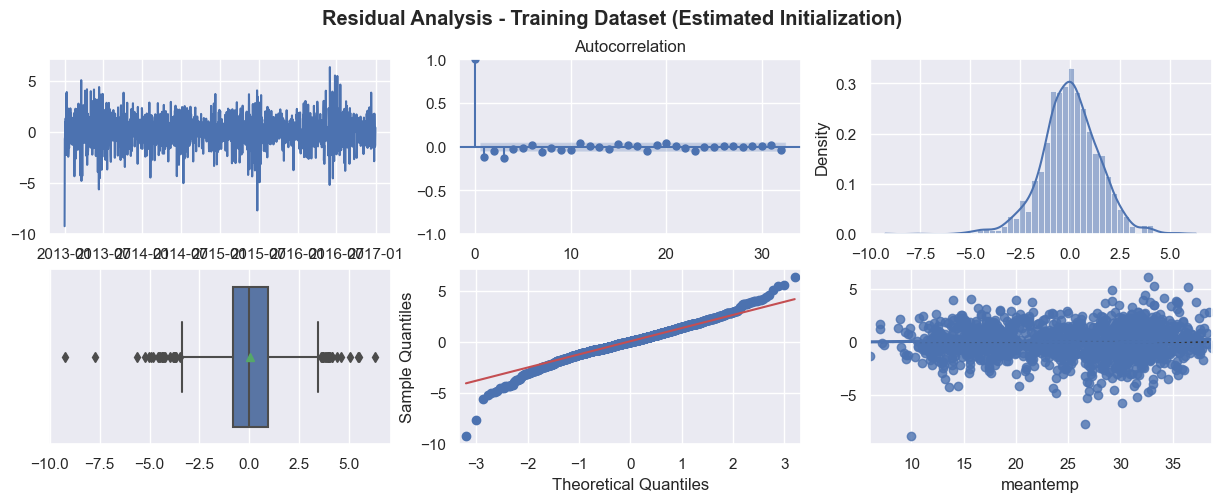

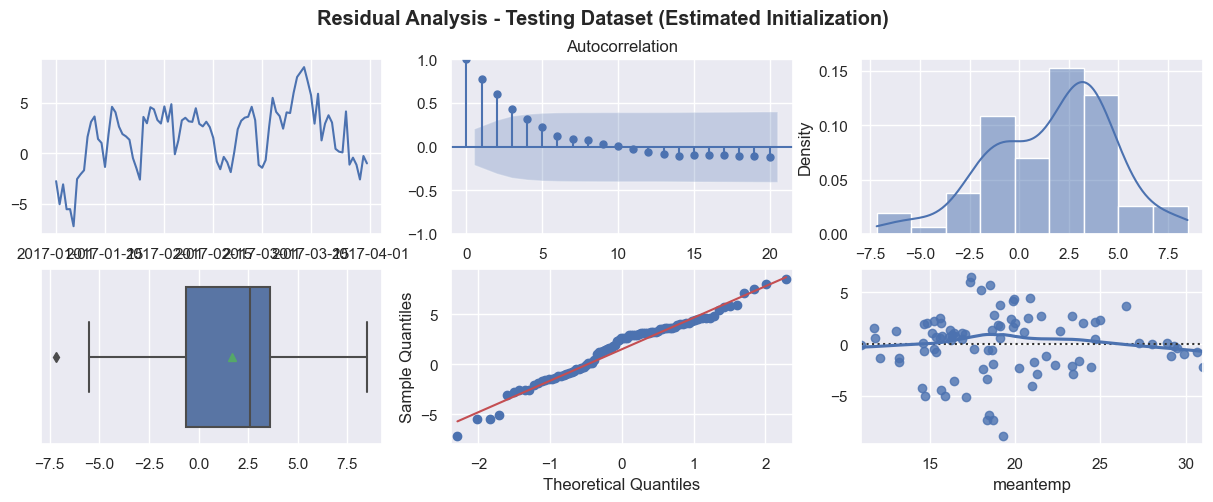

In [14]:
residuals_estimated = model_estimated.resid

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Training Dataset (Estimated Initialization)', weight='bold')
ax[0,0].plot(residuals_estimated)
plot_acf(residuals_estimated, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals_estimated, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals_estimated, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals_estimated, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals_estimated, x=meantemp_train, lowess=True, ax=ax[1,2])
plt.show()

residuals_test_estimated = preds_estimated - meantemp_test

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Testing Dataset (Estimated Initialization)', weight='bold')
ax[0,0].plot(residuals_test_estimated)
plot_acf(residuals_test_estimated, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals_test_estimated, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals_test_estimated, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals_test_estimated, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals_test_estimated, x=meantemp_test, lowess=True, ax=ax[1,2])
plt.show()

### **Second Implementation**

Let's try playing with the model parameters to see if a better forecast can be achieved. 

In particular, the **initialization method** will be set as `heuristic`. This parameter specifies how the initial state parameters of the model are initialized during the fitting process. In this way, such states are initialized using heuristics or rules of thumb rather than through an optiimizion process.

In addition, we will add the option `damped_trend=True`, since these models are renowned for their tendency to **over-forecast**. By enabling this option a new parameter that "dampens" the trend is introduced.

                                 ETS Results                                  
Dep. Variable:               meantemp   No. Observations:                 1461
Model:                      ETS(AAdA)   Log Likelihood               -2666.952
Date:                Wed, 03 Apr 2024   AIC                           5343.904
Time:                        20:04:06   BIC                           5370.338
Sample:                    01-01-2013   HQIC                          5353.765
                         - 12-31-2016   Scale                            2.255
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.7600      0.033     23.109      0.000       0.696       0.824
smoothing_trend       7.6e-05      0.000      0.243      0.808      -0.001       0.001
smoothing_seasonal  

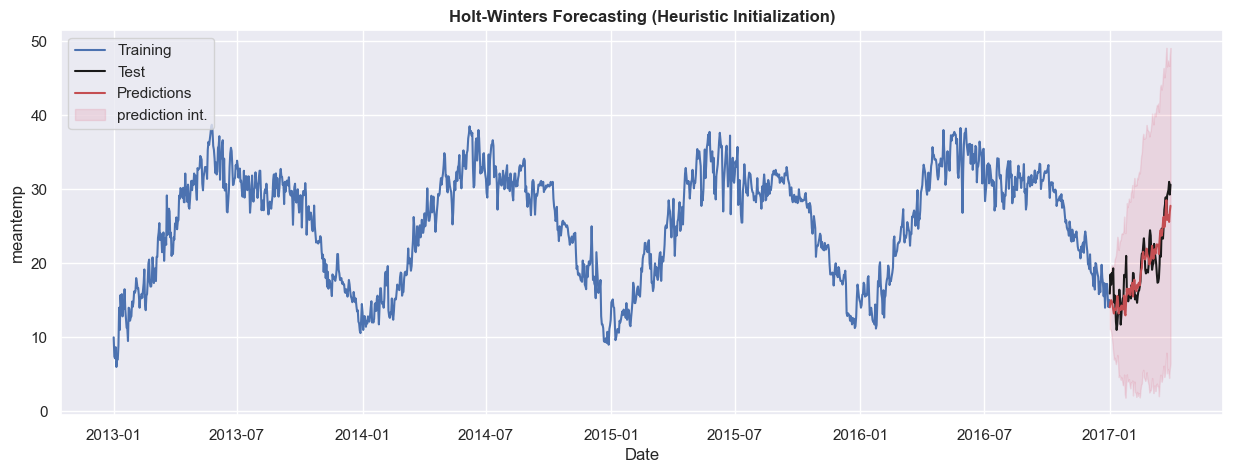

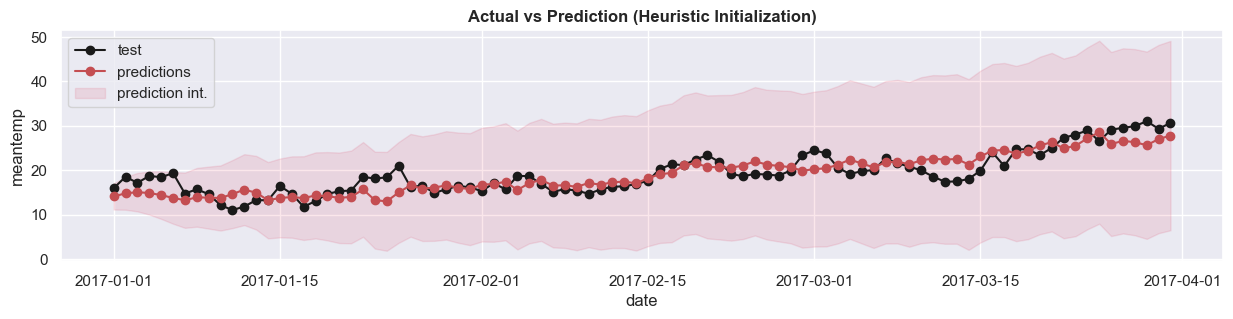

-- Training Evaluation (heuristic initialization)--
MAE training set:  1.1172181006343995
MSE training set:  2.2546197315111156
RMSE training set:  1.501539120872685

-- Testing Evaluation (heuristic initialization) --
MAE test set:  2.079324100862658
MSE test set:  6.418177958198208
RMSE test set:  6.418177958198208
R2 test set:  0.7046814078014426


In [15]:
# focus on forecasting meantemp (avoid other variables)
meantemp_train = train_data['meantemp']
meantemp_test = test_data['meantemp']

# Initializing and fitting the model (heuristic initialization)
model_heuristic = ETSModel(meantemp_train, trend='add', seasonal='add', seasonal_periods=365, damped_trend=True,initialization_method='heuristic').fit()

# printing model summary
print(model_heuristic.summary())

# making predictions on test set
predictions_df_heuristic = model_heuristic.get_prediction(start='2017-01-01', end='2017-03-31').summary_frame()
preds_heuristic = predictions_df_heuristic['mean']

# Plot overall forecasting (training and testing)
plt.figure(figsize=(15,5))
plt.title(f"Holt-Winters Forecasting (Heuristic Initialization)", weight="bold")
plt.plot(meantemp_train, label='Training')
plt.plot(meantemp_test, color='k', label='Test')
plt.plot(preds_heuristic, color='r', label='Predictions')
plt.fill_between(test_data.index, predictions_df_heuristic['pi_lower'], predictions_df_heuristic['pi_upper'], alpha=.1, color='crimson',label='prediction int.')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction (Heuristic Initialization)", weight="bold")
plt.plot(test_data.index, meantemp_test, 'ko-' ,label='test')
plt.plot(test_data.index, preds_heuristic, 'ro-', label='predictions')
plt.fill_between(test_data.index, predictions_df_heuristic['pi_lower'], predictions_df_heuristic['pi_upper'], alpha=.1, color='crimson',label='prediction int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# Evaluating model
# train
mae_train_heuristic = model_heuristic.mae
mse_train_heuristic = model_heuristic.mse
rmse_train_heuristic = np.sqrt(mse_train_heuristic)
# testing
mae_test_heuristic = mean_absolute_error(y_true=meantemp_test, y_pred=preds_heuristic)
mse_test_heuristic = mean_squared_error(y_true=meantemp_test, y_pred=preds_heuristic)
rmse_test_heuristic = root_mean_squared_error(y_true=meantemp_test, y_pred=preds_heuristic)
r2_test_heuristic = r2_score(y_true=meantemp_test, y_pred=preds_heuristic)

print('-- Training Evaluation (heuristic initialization)--')
print('MAE training set: ', mae_train_heuristic)
print('MSE training set: ', mse_train_heuristic)
print('RMSE training set: ', rmse_train_heuristic)

print('\n-- Testing Evaluation (heuristic initialization) --')
print('MAE test set: ', mae_test_heuristic)
print('MSE test set: ', mse_test_heuristic)
print('RMSE test set: ', rmse_test_heuristic)
print('R2 test set: ', r2_test_heuristic)

Through this implementation we achieved a significantly better and faster result in computation, scoring an R2 on the test set of 0.70.

In this case, the heuristic initialization method proved to be better than that estimated in the first implementation.

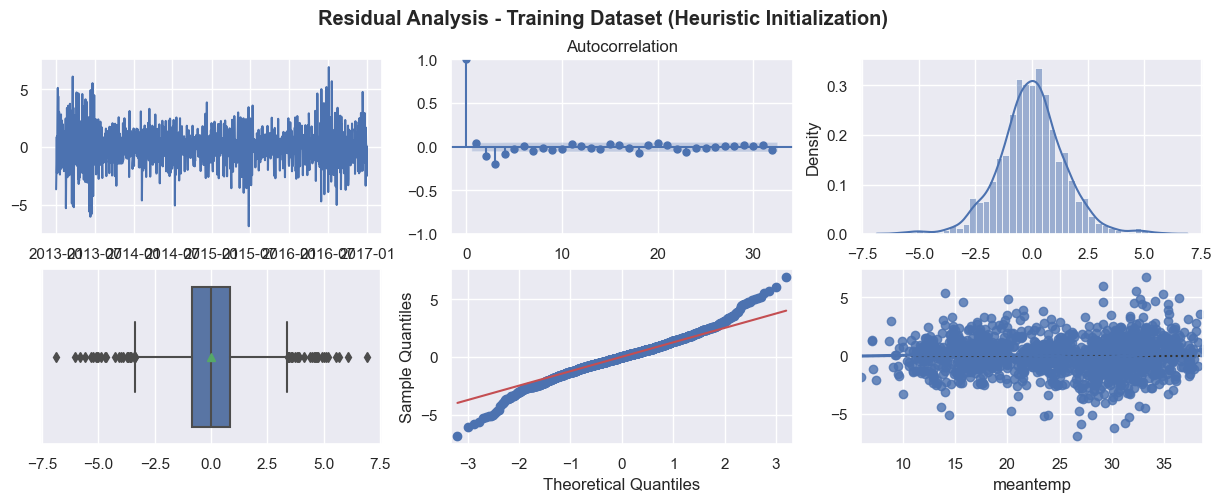

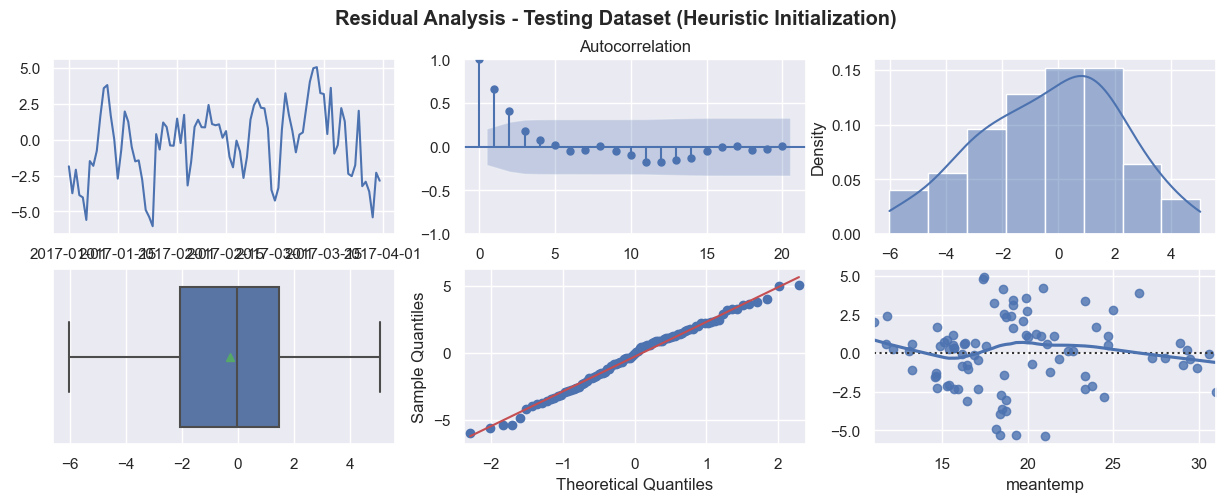

In [16]:
residuals_heuristic = model_heuristic.resid

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Training Dataset (Heuristic Initialization)', weight='bold')
ax[0,0].plot(residuals_heuristic)
plot_acf(residuals_heuristic, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals_heuristic, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals_heuristic, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals_heuristic, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals_heuristic, x=meantemp_train, lowess=True, ax=ax[1,2])
plt.show()

residuals_test_heuristic = preds_heuristic - meantemp_test

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
fig.suptitle(f'Residual Analysis - Testing Dataset (Heuristic Initialization)', weight='bold')
ax[0,0].plot(residuals_test_heuristic)
plot_acf(residuals_test_heuristic, ax=ax[0,1])
# histogram and boxplot to see distribution
sns.histplot(residuals_test_heuristic, kde=True, stat='density', ax=ax[0,2])
sns.boxplot(x=residuals_test_heuristic, ax=ax[1,0], showmeans=True)
# qq-plot 
sm.qqplot(residuals_test_heuristic, line='q', ax=ax[1,1])
# residplot
sns.residplot(y=residuals_test_heuristic, x=meantemp_test, lowess=True, ax=ax[1,2])
plt.show()

## **ARIMA**

While ETS models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

**ARIMA models** require the time-series to be stationary to make effective and precise predictions: a **stationary** time series is one whose statistical properties do not depend on the time of observation. 

Time series with trends or with seasonality are not stationary, as those parameters affect the value of the time series at different points in time. Conversely, a white noise series is stationary, as it does look much the same at any point in time.

There are several ways for checking stationarity, main ones being:
* **ACF Plot**: a stationary time series will not show autocorrelation;
* **ADF** and **KPSS** Tests

### **Daily Frequency Data**

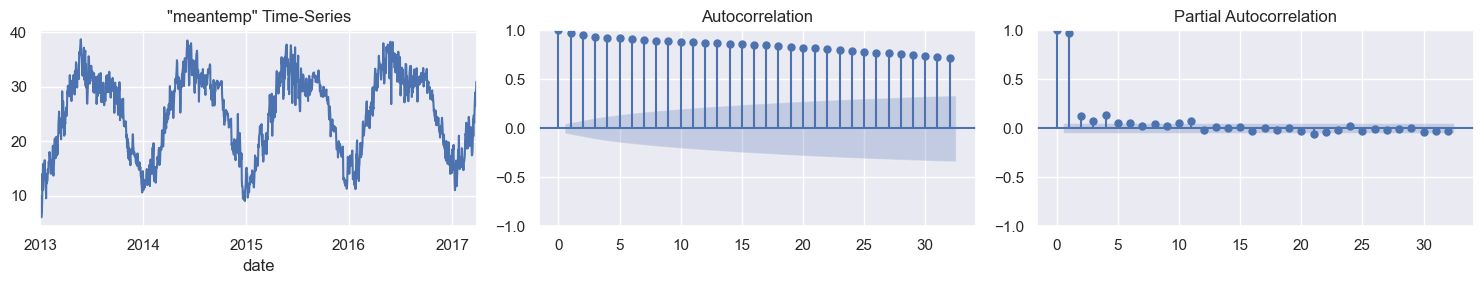

In [31]:
# train and testing
meantemp_train = train_data['meantemp']
meantemp_test = test_data['meantemp']

# merging training and testing to check stationarity
meantemp_tot = pd.concat([meantemp_train, meantemp_test])

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3), tight_layout=True)
meantemp_tot.plot(ax=ax[0])  # weekly
plot_acf(meantemp_tot, ax=ax[1])  # acf
plot_pacf(meantemp_tot, ax=ax[2])  # pacf
ax[0].set_title(f'"meantemp" Time-Series')
plt.show()

In [74]:
# ADF and KPSS Hypothesis Tests
adf_test = adfuller(meantemp_tot, autolag='AIC')
kpss_test = kpss(meantemp_tot, regression='c', nlags='auto', store=True)

# ADF results
adf_value = adf_test[0]
adf_pvalue = adf_test[1]

# kpss results
kpss_value = kpss_test[0]
kpss_pvalue = kpss_test[1]

print(f'=== ADF Test Results ===\n')
print(f'ADF Statistic: {adf_value}')
print(f'ADF p-value: {adf_pvalue}\n')

if adf_pvalue > 0.05:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is not stationary.')
else:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is stationary.')

print(f'\n=== KPSS Test Results ===\n')
print(f'KPSS Statistic: {kpss_value}')
print(f'KPSS p-value: {kpss_pvalue}\n')

if kpss_pvalue <= 0.05:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is not stationary.')
else:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is stationary.')


=== ADF Test Results ===

ADF Statistic: -2.4205718181866813
ADF p-value: 0.13601414402821088

p-value is > 0.05, null hypotesis can't be rejected: the time series is not stationary.

=== KPSS Test Results ===

KPSS Statistic: 0.11213984710650703
KPSS p-value: 0.1

p-value is > 0.05, null hypotesis can't be rejected: the time series is stationary.


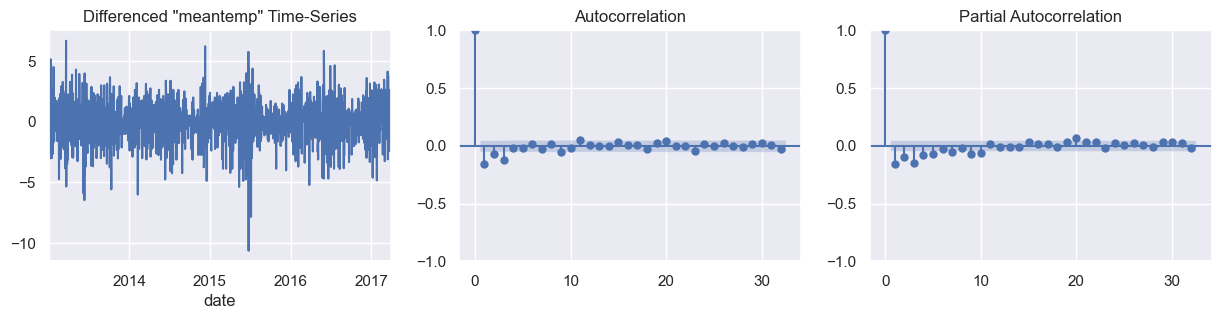

In [71]:
# Differencing to remove trend
meantemp_diff = meantemp_tot.diff(periods=1).dropna()

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
meantemp_diff.plot(ax=ax[0])  # weekly
plot_acf(meantemp_diff, ax=ax[1])  # acf
plot_pacf(meantemp_diff, ax=ax[2])  # pacf
ax[0].set_title(f'Differenced "meantemp" Time-Series')
plt.show()

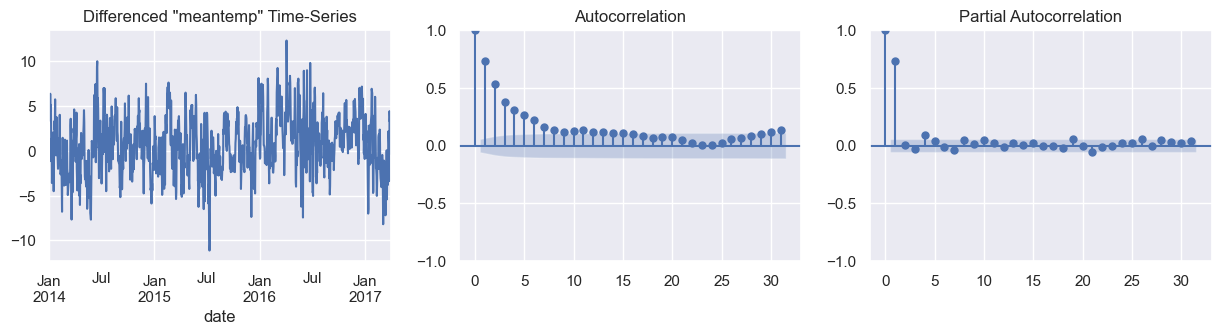

In [92]:
# Differencing to remove trend
meantemp_diff = meantemp_tot.diff(periods=365).dropna()

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
meantemp_diff.plot(ax=ax[0])  # weekly
plot_acf(meantemp_diff, ax=ax[1])  # acf
plot_pacf(meantemp_diff, ax=ax[2])  # pacf
ax[0].set_title(f'Differenced "meantemp" Time-Series')
plt.show()

In [52]:
# ADF and KPSS Hypothesis Tests
adf_test = adfuller(meantemp_diff, autolag='AIC')
kpss_test = kpss(meantemp_diff, regression='ct', nlags='auto', store=True)

# ADF results
adf_value = adf_test[0]
adf_pvalue = adf_test[1]

# kpss results
kpss_value = kpss_test[0]
kpss_pvalue = kpss_test[1]

print(f'=== ADF Test Results ===\n')
print(f'ADF Statistic: {adf_value}')
print(f'ADF p-value: {adf_pvalue}\n')

if adf_pvalue > 0.05:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is not stationary.')
else:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is stationary.')

print(f'\n=== KPSS Test Results ===\n')
print(f'KPSS Statistic: {kpss_value}')
print(f'KPSS p-value: {kpss_pvalue}\n')

if kpss_pvalue <= 0.05:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is not stationary.')
else:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is stationary.')


=== ADF Test Results ===

ADF Statistic: -16.787205651872355
ADF p-value: 1.2504043635728611e-29

p-value is <= 0.05, null hypotesis can be rejected: the time series is stationary.

=== KPSS Test Results ===

KPSS Statistic: 0.053122140190228734
KPSS p-value: 0.1

p-value is > 0.05, null hypotesis can't be rejected: the time series is stationary.


In [32]:
# Fit the model with the selected parameters - Manual SARIMA model 
[p,d,q] = [1,1,0]
[P,D,Q,S] = [1,1,0,365]
model_SARIMA = SARIMAX(meantemp_tot, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='c') # try different trend types
result_SARIMA = model_SARIMA.fit()

# Verify the residuals
print(result_SARIMA.summary())

# Plot diagnostics
result_SARIMA.plot_diagnostics(figsize=(15, 5))

# Forecasting with Auto SARIMA model - Test set
model_SARIMA = result_SARIMA.get_prediction(start=test_data.index[0], end=test_data.index[-1])
df_auto = model_SARIMA.summary_frame()
preds = df_auto['mean']

plt.figure(figsize=(15, 3)) 
plt.plot(meantemp_train, label='Training data')
plt.plot(meantemp_test, color='black', label='Testing data')
plt.plot(df_auto['mean'], color='red', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Cement production')
plt.legend()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - ARIMA(2,1,0)(0,0,0)[365]", weight="bold")
plt.plot(meantemp_test, 'ko-', label='Testing data')
plt.plot(df_auto['mean'], 'ro-', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label=f'95% confidence int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# testing
mae_test = mean_absolute_error(y_true=meantemp_test, y_pred=preds)
mse_test = mean_squared_error(y_true=meantemp_test, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=meantemp_test, y_pred=preds)
r2_test = r2_score(y_true=meantemp_test, y_pred=preds)

print('-- Testing Evaluation ARIMA(2,1,0)(0,0,0)[365] --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2795.537
Date:                Wed, 10 Jul 2024   AIC                           5597.073
Time:                        23:36:31   BIC                           5612.930
Sample:                    01-01-2013   HQIC                          5602.988
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0057      0.044      0.129      0.898      -0.081       0.092
ar.L1         -0.1597      0.020     -7.926      0.000      -0.199      -0.120
sigma2         2.7027      0.075     35.840      0.0

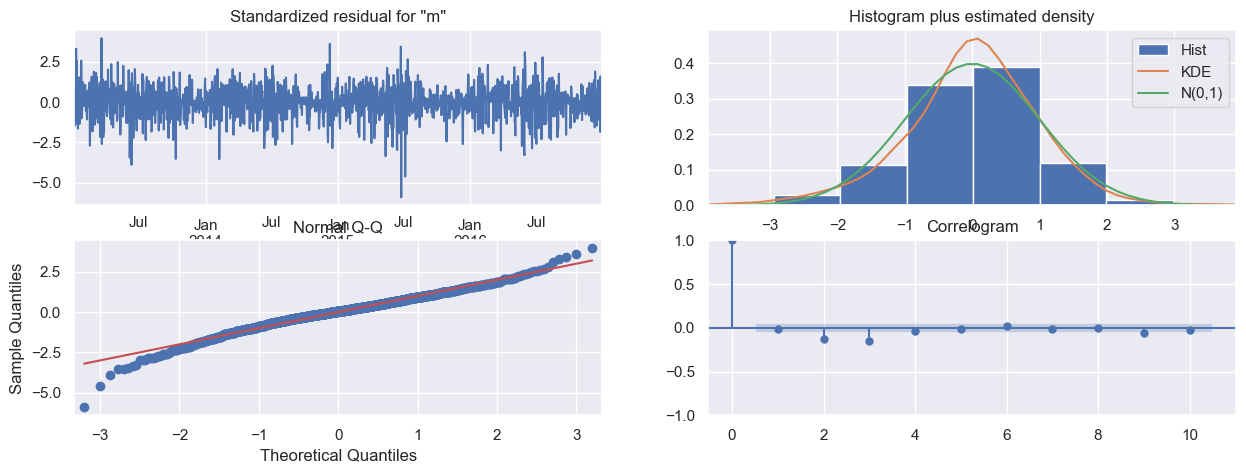

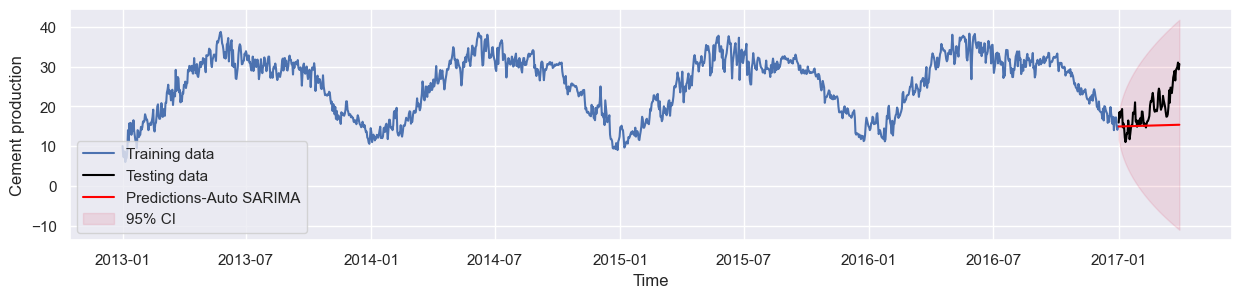

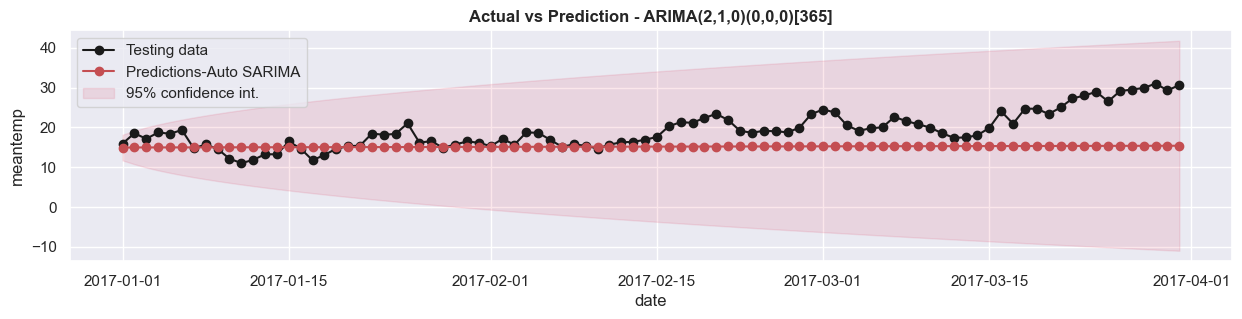

-- Testing Evaluation ARIMA(2,1,0)(0,0,0)[365] --
MAE test set:  4.621098132668677
MSE test set:  38.08569498842307
RMSE test set:  6.1713608700531415
R2 test set:  -0.7524309703064498


In [29]:
# Fit the model with the selected parameters - Manual SARIMA model 
[p,d,q] = [1,1,0]
[P,D,Q,S] = [0,0,0,365]
model_SARIMA = SARIMAX(meantemp_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='c') # try different trend types
result_SARIMA = model_SARIMA.fit()

# Verify the residuals
print(result_SARIMA.summary())

# Plot diagnostics
result_SARIMA.plot_diagnostics(figsize=(15, 5))

# Forecasting with Auto SARIMA model - Test set
model_SARIMA = result_SARIMA.get_prediction(start=test_data.index[0], end=test_data.index[-1])
df_auto = model_SARIMA.summary_frame()
preds = df_auto['mean']

plt.figure(figsize=(15, 3)) 
plt.plot(meantemp_train, label='Training data')
plt.plot(meantemp_test, color='black', label='Testing data')
plt.plot(df_auto['mean'], color='red', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Cement production')
plt.legend()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - ARIMA(2,1,0)(0,0,0)[365]", weight="bold")
plt.plot(meantemp_test, 'ko-', label='Testing data')
plt.plot(df_auto['mean'], 'ro-', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label=f'95% confidence int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# testing
mae_test = mean_absolute_error(y_true=meantemp_test, y_pred=preds)
mse_test = mean_squared_error(y_true=meantemp_test, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=meantemp_test, y_pred=preds)
r2_test = r2_score(y_true=meantemp_test, y_pred=preds)

print('-- Testing Evaluation ARIMA(2,1,0)(0,0,0)[365] --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)

### **Weekly Frequency Upsampling**

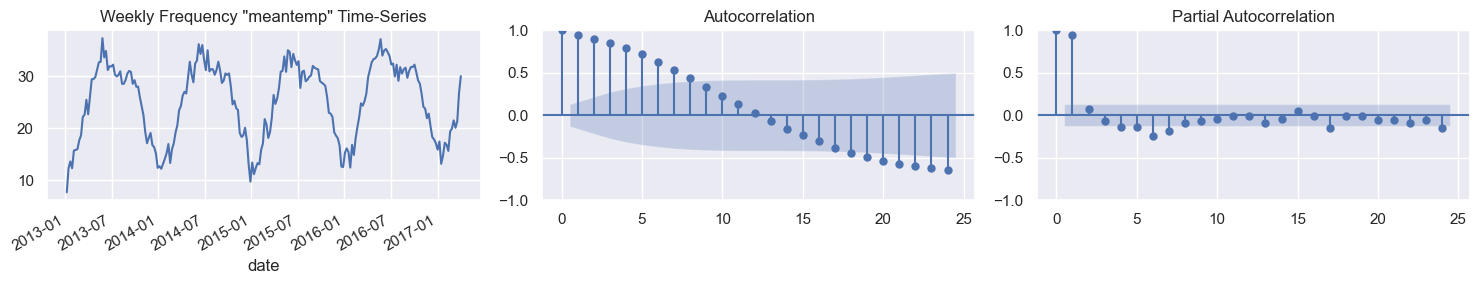

In [7]:
# train and testing
meantemp_train = train_data['meantemp']
meantemp_test = test_data['meantemp']

# resampling from daily to weekly frequency (daily is too computational intensive)
weekly_meantemp_train = meantemp_train.resample('W').mean()
weekly_meantemp_test = meantemp_test.resample('W').mean()

# merging training and testing to check stationarity
weekly_meantemp_tot = pd.concat([weekly_meantemp_train, weekly_meantemp_test])

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3), tight_layout=True)
weekly_meantemp_tot.plot(ax=ax[0])  # weekly
plot_acf(weekly_meantemp_tot, ax=ax[1])  # acf
plot_pacf(weekly_meantemp_tot, ax=ax[2])
ax[0].set_title(f'Weekly Frequency "meantemp" Time-Series')
plt.show()

One way to make the time series stationary is through **differencing**.

We first implement **seasonal differencing**: subtracting the seasonality component from the series (in our case we have weekly data with annual seasonality, so the period will be `53`).

In the case where stationarity has not yet been achieved, an additional differencing step is implemented, this time of only **one period** (`1`).

In [7]:
# ADF and KPSS Hypothesis Tests
adf_test = adfuller(weekly_meantemp_tot, autolag='AIC')
kpss_test = kpss(weekly_meantemp_tot, regression='c', nlags='auto', store=True)

# ADF results
adf_value = adf_test[0]
adf_pvalue = adf_test[1]

# kpss results
kpss_value = kpss_test[0]
kpss_pvalue = kpss_test[1]

print(f'=== ADF Test Results ===\n')
print(f'ADF Statistic: {adf_value}')
print(f'ADF p-value: {adf_pvalue}\n')

if adf_pvalue > 0.05:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is not stationary.')
else:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is stationary.')

print(f'\n=== KPSS Test Results ===\n')
print(f'KPSS Statistic: {kpss_value}')
print(f'KPSS p-value: {kpss_pvalue}\n')

if kpss_pvalue <= 0.05:
    print(f'p-value is <= 0.05, null hypotesis can be rejected: the time series is not stationary.')
else:
    print(f'p-value is > 0.05, null hypotesis can\'t be rejected: the time series is stationary.')


=== ADF Test Results ===

ADF Statistic: -5.516753455664734
ADF p-value: 1.9173637201558864e-06

p-value is <= 0.05, null hypotesis can be rejected: the time series is stationary.

=== KPSS Test Results ===

KPSS Statistic: 0.04837095961445753
KPSS p-value: 0.1

p-value is > 0.05, null hypotesis can't be rejected: the time series is stationary.


Considering a weekly frequency, both **ADF** and **KPSS** tests indicate **stationarity** in our data.

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[53] intercept   : AICC=1422.178, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[53] intercept   : AICC=894.163, Time=1.42 sec
 ARIMA(0,0,1)(0,0,1)[53] intercept   : AICC=inf, Time=3.32 sec
 ARIMA(0,0,0)(0,0,0)[53]             : AICC=1964.731, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[53] intercept   : AICC=899.411, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[53] intercept   : AICC=891.570, Time=12.67 sec
 ARIMA(1,0,0)(3,0,0)[53] intercept   : AICC=inf, Time=39.85 sec
 ARIMA(1,0,0)(2,0,1)[53] intercept   : AICC=inf, Time=63.79 sec
 ARIMA(1,0,0)(1,0,1)[53] intercept   : AICC=inf, Time=5.87 sec
 ARIMA(1,0,0)(3,0,1)[53] intercept   : AICC=inf, Time=144.23 sec
 ARIMA(0,0,0)(2,0,0)[53] intercept   : AICC=inf, Time=38.84 sec
 ARIMA(2,0,0)(2,0,0)[53] intercept   : AICC=inf, Time=18.23 sec
 ARIMA(1,0,1)(2,0,0)[53] intercept   : AICC=888.971, Time=25.74 sec
 ARIMA(1,0,1)(1,0,0)[53] intercept   : AICC=893.401, Time=2.73 sec
 ARIMA(1,0,1)(3,0,0)[53] intercept  

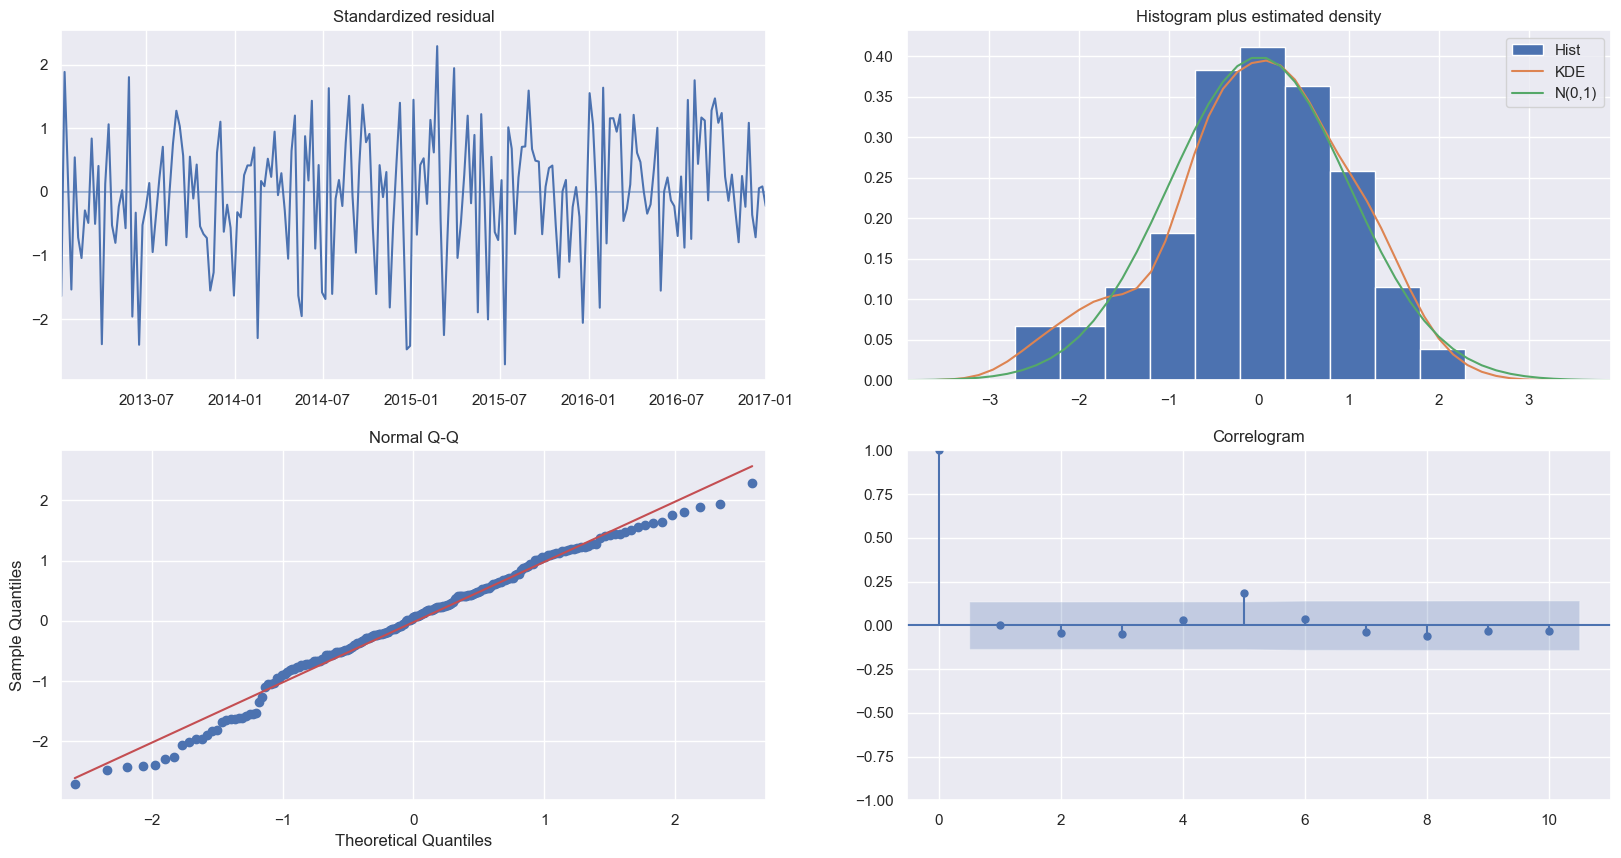

In [67]:
stepwise_model = auto_arima(
    weekly_meantemp_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=1,
    m=53,
    start_P=0, max_P=3,
    start_Q=0, max_Q=3,
    D=1,
    seasonal=True,
    trace=True, information_criterion='aicc',
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())
stepwise_model.plot_diagnostics(figsize=(20, 10))

c:\Users\marco\OneDrive\Documenti\Università\Project_SM4DS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                  209
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -422.847
Date:                Wed, 10 Jul 2024   AIC                            859.695
Time:                        23:17:21   BIC                            882.990
Sample:                    01-06-2013   HQIC                           869.116
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.247      2.998      0.003       0.256       1.224
drift         -0.0004      0.001     -0.464      0.643      -0.002       0.001
ar.L1          1.8821      0.061     30.766      0.0

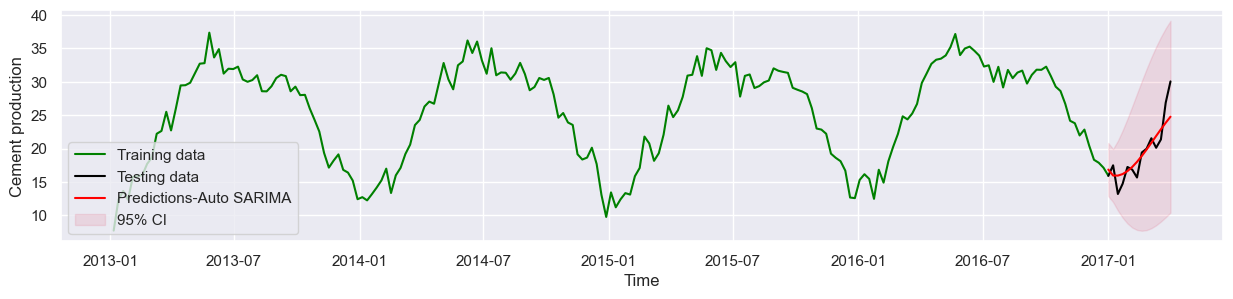

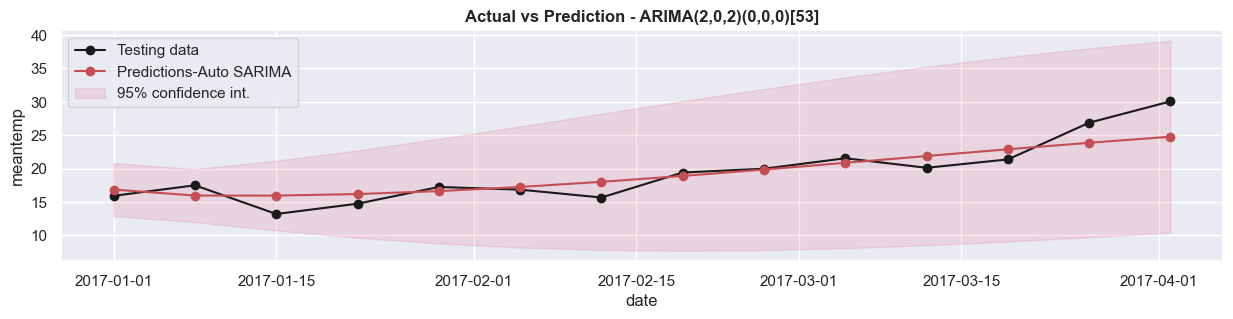

-- Testing Evaluation ARIMA(2,0,2)(0,0,0)[53] --
MAE test set:  1.638973665464207
MSE test set:  4.440711017335823
RMSE test set:  2.1072994607638997
R2 test set:  0.7779685047577828


In [8]:
# Fit the model with the selected parameters - Manual SARIMA model 
[p,d,q] = [2,0,2]
[P,D,Q,S] = [0,0,0,53]
model_SARIMA = SARIMAX(weekly_meantemp_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='ct') # try different trend types
result_SARIMA = model_SARIMA.fit()

# Verify the residuals
print(result_SARIMA.summary())

# Forecasting with Auto SARIMA model - Test set
model_SARIMA = result_SARIMA.get_prediction(start=weekly_meantemp_test.index[0], end=weekly_meantemp_test.index[-1])
df_auto = model_SARIMA.summary_frame()
preds = df_auto['mean']

plt.figure(figsize=(15, 3)) 
plt.plot(weekly_meantemp_train, color='green',label='Training data')
plt.plot(weekly_meantemp_test, color='black', label='Testing data')
plt.plot(df_auto['mean'], color='red', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Cement production')
plt.legend()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - ARIMA(2,0,2)(0,0,0)[53]", weight="bold")
plt.plot(weekly_meantemp_test, 'ko-', label='Testing data')
plt.plot(df_auto['mean'], 'ro-', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label=f'95% confidence int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# testing
mae_test = mean_absolute_error(y_true=weekly_meantemp_test, y_pred=preds)
mse_test = mean_squared_error(y_true=weekly_meantemp_test, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=weekly_meantemp_test, y_pred=preds)
r2_test = r2_score(y_true=weekly_meantemp_test, y_pred=preds)

print('-- Testing Evaluation ARIMA(2,0,2)(0,0,0)[53] --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)

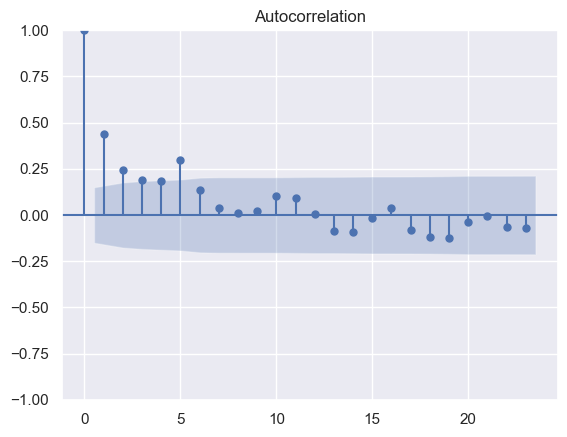

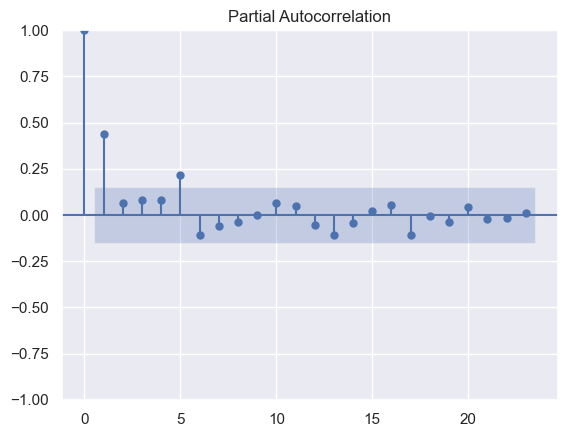

In [18]:
x = weekly_meantemp_tot.diff(52).dropna()
plot_acf(x)
plot_pacf(x)
plt.show()

c:\Users\marco\OneDrive\Documenti\Università\Project_SM4DS\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\marco\OneDrive\Documenti\Università\Project_SM4DS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                meantemp   No. Observations:                  209
Model:             SARIMAX(2, 0, 0)x(2, 1, [1, 2], 53)   Log Likelihood                 -92.240
Date:                                 Wed, 10 Jul 2024   AIC                            202.481
Time:                                         23:32:31   BIC                            219.322
Sample:                                     01-06-2013   HQIC                           208.845
                                          - 01-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0708      4.119     -0.017      0.986      -8.144       8

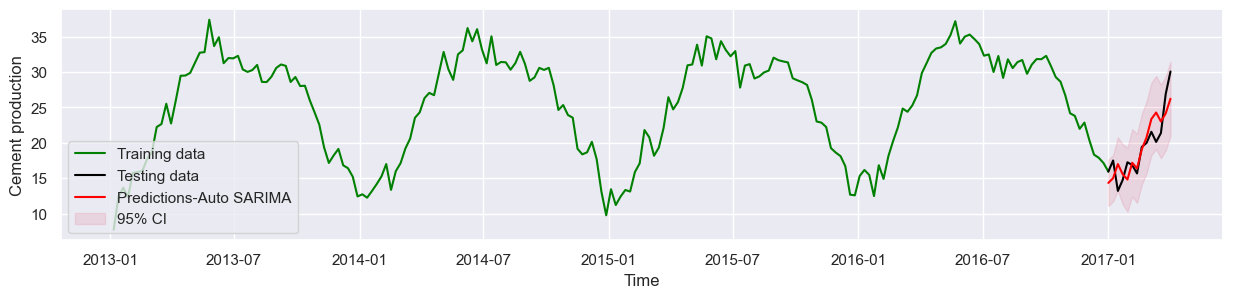

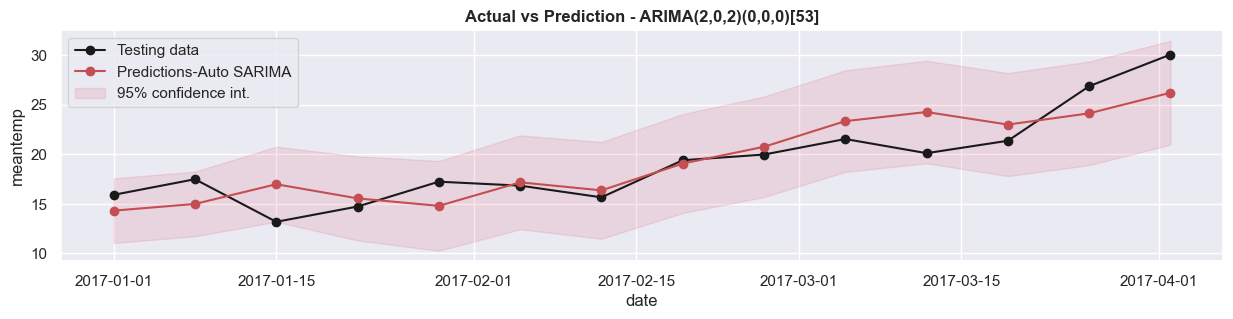

-- Testing Evaluation ARIMA(2,0,2)(0,0,0)[53] --
MAE test set:  1.9620619523413685
MSE test set:  5.466443222518764
RMSE test set:  2.338042604940886
R2 test set:  0.7266828312821196


In [25]:
# Fit the model with the selected parameters - Manual SARIMA model 
[p,d,q] = [2,0,0]
[P,D,Q,S] = [2,1,2,53]
model_SARIMA = SARIMAX(weekly_meantemp_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='ct') # try different trend types
result_SARIMA = model_SARIMA.fit()

# Verify the residuals
print(result_SARIMA.summary())

# Forecasting with Auto SARIMA model - Test set
model_SARIMA = result_SARIMA.get_prediction(start=weekly_meantemp_test.index[0], end=weekly_meantemp_test.index[-1])
df_auto = model_SARIMA.summary_frame()
preds = df_auto['mean']

plt.figure(figsize=(15, 3)) 
plt.plot(weekly_meantemp_train, color='green',label='Training data')
plt.plot(weekly_meantemp_test, color='black', label='Testing data')
plt.plot(df_auto['mean'], color='red', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Cement production')
plt.legend()

# Plotting predictions vs actual values (focus on test data)
plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - ARIMA(2,0,2)(0,0,0)[53]", weight="bold")
plt.plot(weekly_meantemp_test, 'ko-', label='Testing data')
plt.plot(df_auto['mean'], 'ro-', label='Predictions-Auto SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label=f'95% confidence int.')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

# testing
mae_test = mean_absolute_error(y_true=weekly_meantemp_test, y_pred=preds)
mse_test = mean_squared_error(y_true=weekly_meantemp_test, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=weekly_meantemp_test, y_pred=preds)
r2_test = r2_score(y_true=weekly_meantemp_test, y_pred=preds)

print('-- Testing Evaluation ARIMA(2,0,2)(0,0,0)[53] --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)

## **ARCH** & **GARCH**

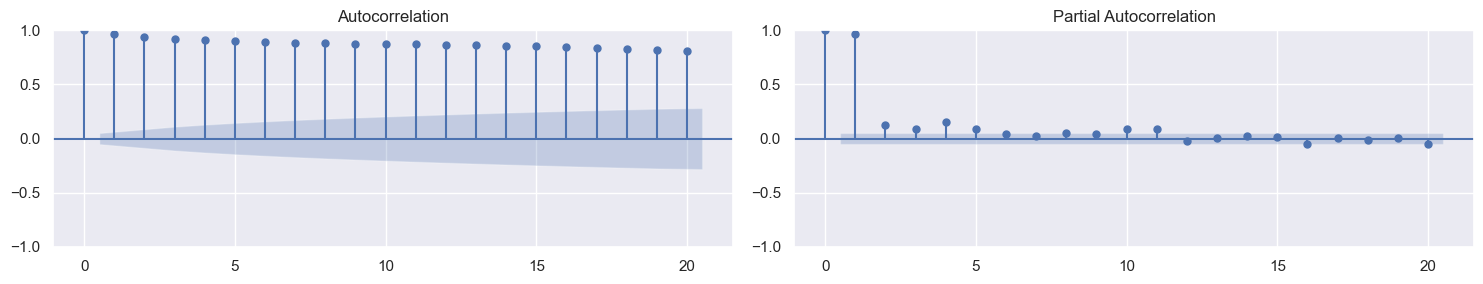

In [27]:
meantemp_train_squared = meantemp_train ** 2
meantemp_test_squared = meantemp_test ** 2

fig, ax = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(15,3))
plot_acf(meantemp_train_squared, lags=20, ax=ax[0])
plot_pacf(meantemp_train_squared, lags=20, ax=ax[1])
plt.show()

In [30]:
test_het = het_arch(meantemp_train_squared, nlags=10)
test_het

(1300.9052323167805, 2.439744253347328e-273, 1248.0805050378847, 0.0)

## **Prophet**

01:28:42 - cmdstanpy - INFO - Chain [1] start processing
01:28:42 - cmdstanpy - INFO - Chain [1] done processing


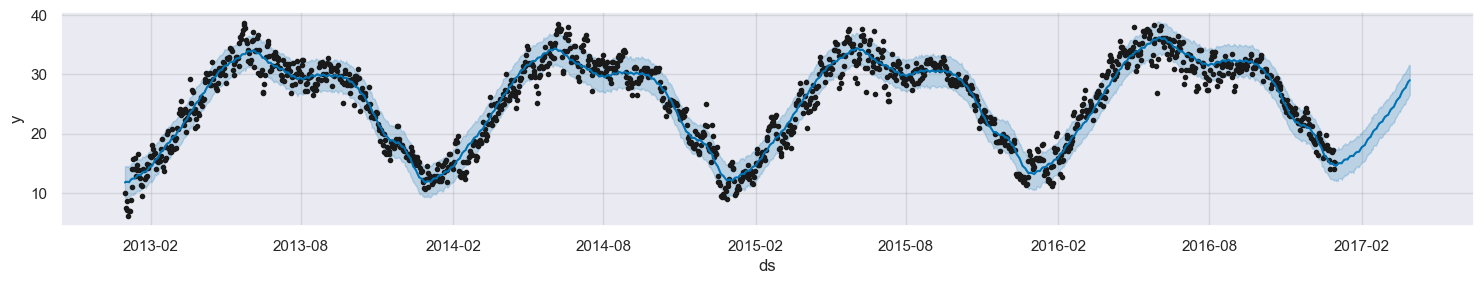

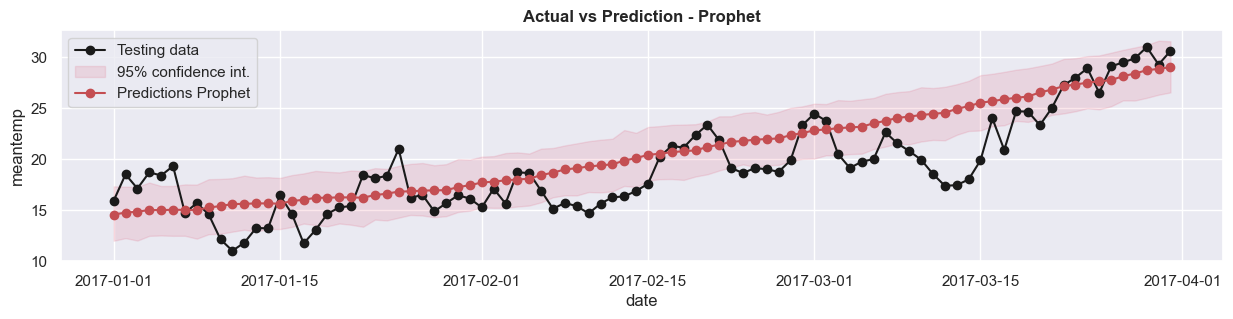

-- Testing Evaluation Prophet Model --
MAE test set:  2.407245670385559
MSE test set:  8.447431950925024
RMSE test set:  2.906446619314558
R2 test set:  0.61130966955291


In [165]:
train_data_no_index = train_data.reset_index()
train_data_prophet = train_data_no_index.rename(columns={'date': 'ds', 'meantemp': 'y'})

test_data_no_index = test_data.reset_index()
test_data_prophet = test_data_no_index.rename(columns={'date': 'ds', 'meantemp': 'y'})

model = Prophet(yearly_seasonality=True, daily_seasonality=False)

model.fit(train_data_prophet)

future = model.make_future_dataframe(periods=90, freq='D')

future = model.predict(future)


model.plot(future,figsize=(15,3))
plt.show()

preds_df = future.iloc[-90:].set_index('ds')

correct = test_data['meantemp']
preds = preds_df['yhat']

plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - Prophet", weight="bold")
plt.plot(correct, 'ko-', label='Testing data')
plt.fill_between(preds_df.index, preds_df['yhat_lower'], preds_df['yhat_upper'], alpha=.1, color='crimson', label=f'95% confidence int.')
plt.plot(preds_df['yhat'], 'ro-', label='Predictions Prophet')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

mae_test = mean_absolute_error(y_true=correct, y_pred=preds)
mse_test = mean_squared_error(y_true=correct, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=correct, y_pred=preds)
r2_test = r2_score(y_true=correct, y_pred=preds)

print('-- Testing Evaluation Prophet Model --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)

In [212]:
import xgboost as xgb

train_data['day_of_week'] = train_data.index.day_of_week
train_data['day_of_year'] = train_data.index.day_of_year

test_data['day_of_week'] = test_data.index.day_of_week
test_data['day_of_year'] = test_data.index.day_of_year

X_train = train_data.drop(columns=['meantemp', 'humidity', 'wind_speed', 'meanpressure'])
y_train = train_data['meantemp']

X_test = test_data.drop(columns=['meantemp', 'humidity', 'wind_speed', 'meanpressure'])
y_test = test_data['meantemp']

display(X_train)

model = xgb.XGBRegressor(n_estimators=2500, early_stopping_rounds=100, learning_rate=0.01)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

,month,year,day_of_week,day_of_year
date,,,,
2013-01-01,1,2013,1,1
2013-01-02,1,2013,2,2
2013-01-03,1,2013,3,3
2013-01-04,1,2013,4,4
2013-01-05,1,2013,5,5
...,...,...,...,...
2016-12-27,12,2016,1,362
2016-12-28,12,2016,2,363
2016-12-29,12,2016,3,364


[0]	validation_0-rmse:7.26993	validation_1-rmse:7.68440
[1]	validation_0-rmse:7.20367	validation_1-rmse:7.60947
[2]	validation_0-rmse:7.13810	validation_1-rmse:7.53540
[3]	validation_0-rmse:7.07324	validation_1-rmse:7.46220
[4]	validation_0-rmse:7.00906	validation_1-rmse:7.39006
[5]	validation_0-rmse:6.94556	validation_1-rmse:7.31856
[6]	validation_0-rmse:6.88274	validation_1-rmse:7.24812
[7]	validation_0-rmse:6.82060	validation_1-rmse:7.17832
[8]	validation_0-rmse:6.75907	validation_1-rmse:7.10953
[9]	validation_0-rmse:6.69801	validation_1-rmse:7.04159
[10]	validation_0-rmse:6.63801	validation_1-rmse:6.97427
[11]	validation_0-rmse:6.57862	validation_1-rmse:6.90773
[12]	validation_0-rmse:6.51991	validation_1-rmse:6.84202
[13]	validation_0-rmse:6.46134	validation_1-rmse:6.77727
[14]	validation_0-rmse:6.40386	validation_1-rmse:6.71316
[15]	validation_0-rmse:6.34683	validation_1-rmse:6.65002
[16]	validation_0-rmse:6.29033	validation_1-rmse:6.58761
[17]	validation_0-rmse:6.23466	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [206]:
model.feature_importances_

array([0.13612497, 0.03574482, 0.00469236, 0.8234378 ], dtype=float32)

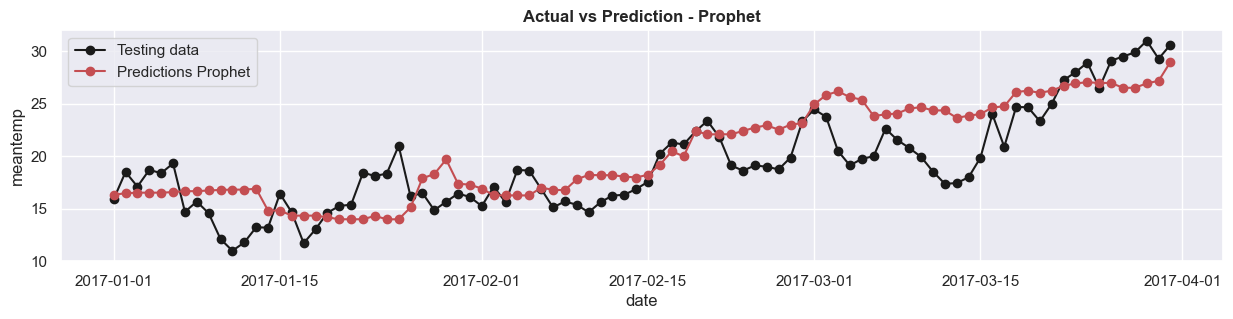

-- Testing Evaluation Prophet Model --
MAE test set:  2.4932145226720706
MSE test set:  9.294684830410834
RMSE test set:  3.0487185554607747
R2 test set:  0.5723251588030451


In [213]:
preds_values = model.predict(X_test)

correct = test_data['meantemp']
preds = pd.Series(data=preds_values, index=test_data.index)

plt.figure(figsize=(15,3))
plt.title(f"Actual vs Prediction - Prophet", weight="bold")
plt.plot(correct, 'ko-', label='Testing data')
plt.plot(preds, 'ro-', label='Predictions Prophet')
plt.xlabel('date')
plt.ylabel('meantemp')
plt.legend(loc='upper left')
plt.show()

mae_test = mean_absolute_error(y_true=correct, y_pred=preds)
mse_test = mean_squared_error(y_true=correct, y_pred=preds)
rmse_test = root_mean_squared_error(y_true=correct, y_pred=preds)
r2_test = r2_score(y_true=correct, y_pred=preds)

print('-- Testing Evaluation Prophet Model --')
print('MAE test set: ', mae_test)
print('MSE test set: ', mse_test)
print('RMSE test set: ', rmse_test)
print('R2 test set: ', r2_test)